# Homework 7: Exploring and Analyzing the Pinal County MODFLOW Model

## Introduction

In this assignment, you will work with a real-world, professional groundwater model from the Arizona Department of Water Resources (ADWR). As you know, the Pinal County model represents the Pinal Active Management Area in central Arizona and includes:
- 3 layers (vs 1 layer in tutorials), plus much larger spatial extent
- Monthly stress periods tracking transient pumping impacts
- Real pumping data from wells across the basin

## Learning Objectives

By completing this assignment, you will:
1. Load and inspect a large, multi-layer, transient groundwater model
2. Visualize model input parameters including hydraulic conductivity and well locations
3. Run the model and verify successful execution
4. Evaluate temporal changes in hydraulic head at specific locations

## The Model

You have been provided with **`PM_AWS2019_SS25115.nam`** in the `model_input_directory` folder, which includes (among many other files):
- WEL (Well) package with pumping wells
- LPF (Layer Property Flow) package with spatially-variable hydraulic conductivity
- RCH (Recharge) and EVT (Evapotranspiration) packages
- CHD (Constant Head) boundaries representing regional flow
- 194 stress periods 

You will first explore the model structure (visualizing K, wells), then run the simulation, and finally analyze the results to understand how pumping affects the aquifer.

## Setup: Import Required Packages

In [1]:
# TODO: Add your imports here
import os
import flopy

# Part 1: Load and Explore the Model

Following the pattern from Tutorial 2, you will:
1. Load the model from its namelist file
2. Explore the model structure by visualizing key input parameters
3. Run the model and verify successful execution

Before running a model, it's good practice to examine its structure, boundary conditions, and stresses. This helps you understand what the model represents and identify potential issues.

## 1.1: Define Paths and Model Names

In [2]:
# NOTE: Nothing to change in this cell
# Path to the MODFLOW executable
modflow_path = '../../../../modflow/mf2005' 

# Unzip the model files
if os.path.exists('../../../pinal_county_model/'):
    print("Model files already unzipped.")
else:
    ! unzip ../../../pinal_county_model.zip -d ../../../

# Directory containing the original model files
# NOTE: The model output will be saved in the same directory
model_input_dir = '../../../pinal_county_model/'

# Namelist file
nam_file = 'PM_AWS2019_SS25115.nam'

Model files already unzipped.


## 1.2: Load the Model

In [3]:
# Load the model
print("Loading Pinal County model... (this may take a moment)")
# TODO: Fill in the None parts here.
m = flopy.modflow.Modflow.load(
    f=nam_file, # Namelist file
    exe_name=modflow_path,
    model_ws=model_input_dir, # Model workspace (directory)
    check=False  # Skip detailed checking due to formatting quirks
)

print("Model loaded successfully!")
print(m)

Loading Pinal County model... (this may take a moment)
Model loaded successfully!
MODFLOW 3 layer(s) 196 row(s) 222 column(s) 194 stress period(s)


## Inspect the Model Packages

In [4]:
print("Available packages:")
print(m.get_package_list())
print("="*60)

# TODO: Fill in the None parts here
print(f"\nModel dimensions:")
print(f"  Layers: {3}")
print(f"  Rows: {196}")
print(f"  Columns: {222}")
print(f"  Total cells: {3 * 196 * 222}")
print(f"  Stress periods: {194}")

# Get stress period 0 well data
# TODO: Fill in the None parts here
wel_data_sp0 = m.wel.stress_period_data [0]
print(f"  Number of wells in first stress period: {len(wel_data_sp0)}")
print(f"  Total pumping rate (first stress period): {wel_data_sp0['flux'].sum():.2e} ft³/day")
print()

# Get the last stress period well data
# TODO: Fill in the None parts here
well_data_last = m.wel.stress_period_data [193]
print(f"  Number of wells in last stress period: {len(well_data_last)}")
print(f"  Total pumping rate (last stress period): {well_data_last['flux'].sum():.2e} ft³/day")

Available packages:
['DIS', 'BAS6', 'LPF', 'WEL', 'MNW2', 'MNWI', 'EVT', 'RCH', 'CHD', 'SWT', 'STR', 'HOB', 'OC', 'GMG']

Model dimensions:
  Layers: 3
  Rows: 196
  Columns: 222
  Total cells: 130536
  Stress periods: 194
  Number of wells in first stress period: 209
  Total pumping rate (first stress period): 4.20e+06 ft³/day

  Number of wells in last stress period: 223
  Total pumping rate (last stress period): 4.15e+06 ft³/day


# Create a figure showing the wells and conductivity across the model domain

Your figure should include:
- 3 subplots (one for each layer)
- Color map (using `imshow`) of hydraulic conductivity
- Well locations overlaid as points, colored by pumping rate (be sure to set `vmin` and `vmax` for the color scale)

Additionally, try looking at other stress periods to see how pumping changes over time.

In [5]:
def get_well_data_for_layer_and_stress_period(m_wel, layer, stress_period):
    """Helper function to extract well data for a specific layer and stress period."""
    # NOTE: nothing to do here
    wel_data = m_wel.stress_period_data[stress_period]
    return wel_data[wel_data['k'] == layer]


# Get hydraulic conductivity array - you might want to check the shape and values
# TODO: Fill in the None parts here
hk = m.lpf.hk.array # Horizontal hydraulic conductivity


In [6]:
import matplotlib.pyplot as plt
import numpy as np

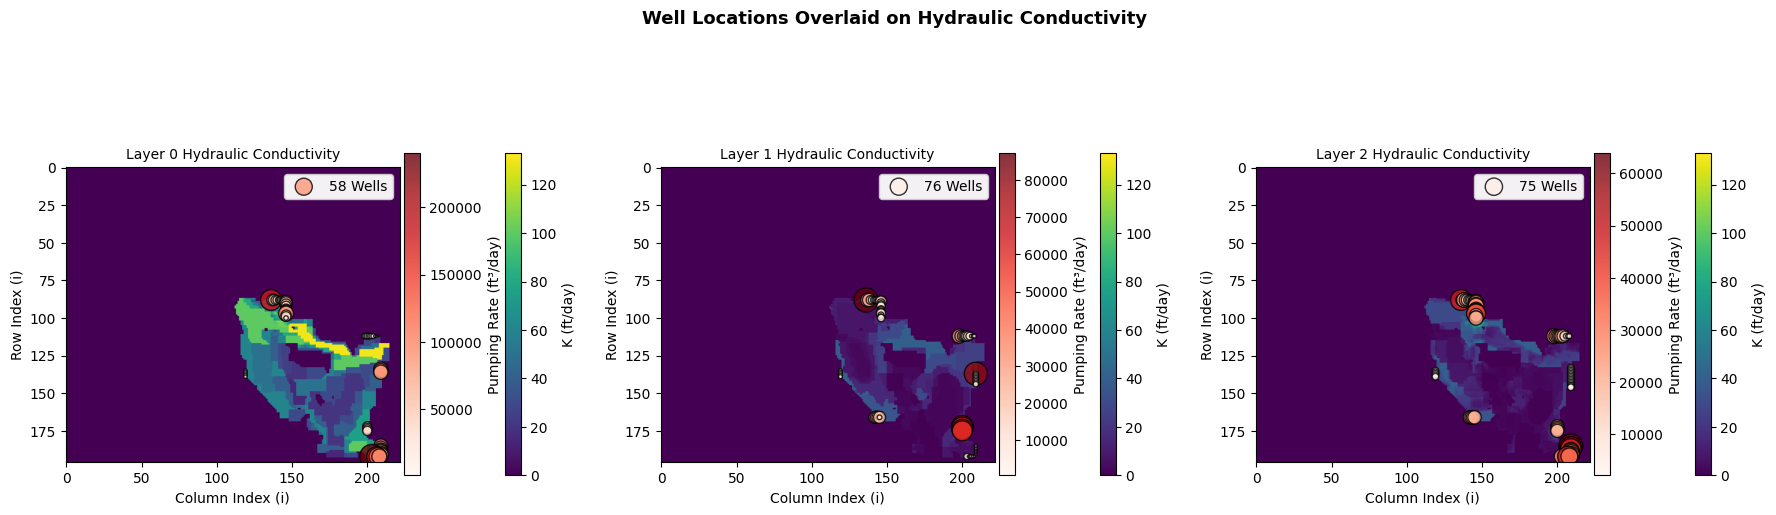

In [7]:
## TODO: Loop through each layer and plot
# Create 1 x 3 figure for plotting the individual layers
# Use a figsize (18, 6) for decent visibility
# TODO: Fill in the None parts here
fig, axes = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle(f'Well Locations Overlaid on Hydraulic Conductivity', 
             fontsize=13, fontweight='bold')

# TODO: Fill in the None parts here
for layer_to_plot in range(3):

    # Plot K field as background first
    ax = axes[layer_to_plot]
    im = ax.imshow(hk[layer_to_plot, :, :], cmap='viridis', 
                    vmin = np.nanmin(hk), vmax=np.nanmax(hk),)
    ax.set_title(f'Layer {layer_to_plot} Hydraulic Conductivity', fontsize = 10)
    ax.set_xlabel('Column Index (i)')
    ax.set_ylabel('Row Index (i)')
    plt.colorbar(im, ax=ax, label='K (ft/day)', shrink=0.6, pad=0.08)

    # Get well data for this layer and stress period 0
    wells_in_layer = get_well_data_for_layer_and_stress_period(m.wel, layer_to_plot, 0)
    # Now pull out the `i`, `j`, and `flux` columns
    well_rows_layer = wells_in_layer['i']
    well_cols_layer = wells_in_layer['j']
    pump_rates_layer = wells_in_layer['flux']

    # Convert to positive values for sizing and coloring
    # NOTE: nothing to do here
    abs_pump_rates = np.abs(pump_rates_layer)
    # Normalize marker sizes (scale to reasonable range)
    # NOTE: nothing to do here
    marker_sizes = (abs_pump_rates / abs_pump_rates.max()) * 300

    # Overlay well locations
    # NOTE: nothing to do here
    scatter = ax.scatter(well_cols_layer, well_rows_layer, 
                         s=marker_sizes,           # Size proportional to pumping rate
                         c=abs_pump_rates,         # Color by absolute pumping rate
                         cmap='Reds',              # Red colormap
                         alpha=0.8,
                         edgecolors='black',
                         linewidths=1,
                         marker='o',
                         label=f'{len(wells_in_layer)} Wells')
    # Add colorbar for pumping rates
    cbar_wells = plt.colorbar(scatter, ax=ax, label='Pumping Rate (ft³/day)', 
                              shrink=0.6, pad=0.01)

    ax.legend(loc='upper right', fontsize=10, framealpha=0.95)

plt.tight_layout()

In [8]:
# Run the model - this will take a few minutes
# TODO: Fill in the None parts here, and set `silent=False` to see the output, 
#       and `pause=False` to avoid waiting for user input
success, buff = m.run_model(silent=False, pause=False)

# NOTE: The model output will be saved in the same directory as the input files
# NOTE: Nothing to do here
if success:
    print("\n" + "="*60)
    print("Model run completed successfully!")
    print("="*60)
else:
    print("\n" + "="*60)
    print("ERROR: Model run failed!")
    print("="*60)
    raise Exception("Model run failed. Check the .list file for errors.")

FloPy is using the following executable to run the model: ../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: PM_AWS2019_SS25115.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/19 19:54:20



 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Wa

## 2.3: Calculate Drawdown

Drawdown is the lowering of the water table due to pumping. It's calculated as the change from initial to final conditions:

$$\text{Drawdown} = \text{Head}_{\text{initial}} - \text{Head}_{\text{final}}$$

Positive drawdown values indicate head lowering during the simulation. For this analysis, we will focus on the first layer, but you can extend it to other layers if desired. To complete this part, you will:
1. Load the initial and final head arrays
2. Calculate the drawdown
3. Analyze the drawdown statistics (max, mean, min)
4. Make a 3 panel figure showing initial heads, final heads, and drawdown

Make sure to clearly label your plots and choose appropriate color scales/maps.

In [9]:
# Path to head file
hds_file = f'{model_input_dir}/Pinal.hds'

# TODO: Fill in the None parts here
# Load head file
hds = flopy.utils.HeadFile(hds_file)
# Get the times - this will be used for loading initial and final heads
times = hds.get_times()

In [10]:
# Get initial heads (first time step)
missing_value = -999.00
# TODO: Fill in the None parts here
heads_initial = hds.get_data(totim = times[0])
heads_initial[heads_initial <= missing_value] = np.nan  # Replace missing values with NaN

# Get final heads (last time step)
# TODO: Fill in the None parts here
heads_final = hds.get_data(totim = times[-1])
heads_final[heads_final <= missing_value] = np.nan  # Replace missing values with NaN

# Print array information - this should help you understand the structure of the head data
print(f"Initial heads shape: {heads_initial.shape}")
print(f"Final heads shape: {heads_final.shape}")
print(f"\nArray dimensions: (layers, rows, columns)")
print(f"  Layers: {heads_initial.shape[0]}")
print(f"  Rows: {heads_initial.shape[1]}")
print(f"  Columns: {heads_initial.shape[2]}")

# Print basic statistics for layer 1 (index 0)
print(f"\nLayer 1 head statistics (INITIAL - Time = {times[0]:.1f} days):")
print(f"  Min: {np.nanmin(heads_initial[0, :, :]):.2f} ft")
print(f"  Max: {np.nanmax(heads_initial[0, :, :]):.2f} ft")
print(f"  Mean: {np.nanmean(heads_initial[0, :, :]):.2f} ft")

print(f"\nLayer 1 head statistics (FINAL - Time = {times[-1]:.1f} days):")
print(f"  Min: {np.nanmin(heads_final[0, :, :]):.2f} ft")
print(f"  Max: {np.nanmax(heads_final[0, :, :]):.2f} ft")
print(f"  Mean: {np.nanmean(heads_final[0, :, :]):.2f} ft")

print(f"\nLayer 1 head statistics (FINAL - Time = {times[-1]:.1f} days):")
print(f"  Min: {np.nanmin(heads_final[0, :, :]):.2f} ft")
print(f"  Max: {np.nanmax(heads_final[0, :, :]):.2f} ft")
print(f"  Mean: {np.nanmean(heads_final[0, :, :]):.2f} ft")

Initial heads shape: (3, 196, 222)
Final heads shape: (3, 196, 222)

Array dimensions: (layers, rows, columns)
  Layers: 3
  Rows: 196
  Columns: 222

Layer 1 head statistics (INITIAL - Time = 1.0 days):
  Min: 1000.00 ft
  Max: 1700.50 ft
  Mean: 1318.53 ft

Layer 1 head statistics (FINAL - Time = 70493.5 days):
  Min: 931.67 ft
  Max: 1568.80 ft
  Mean: 1152.73 ft

Layer 1 head statistics (FINAL - Time = 70493.5 days):
  Min: 931.67 ft
  Max: 1568.80 ft
  Mean: 1152.73 ft


Drawdown statistics (Layer 1):
  Maximum drawdown: 342.40 ft
  Mean drawdown: 145.46 ft
  Minimum drawdown: 0.00 ft


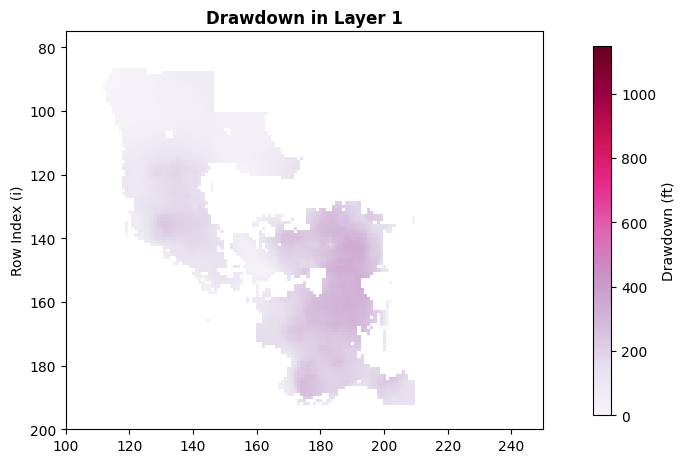

In [13]:
# Calculate drawdown (positive = head lowering)
drawdown = heads_initial - heads_final

print(f"Drawdown statistics (Layer 1):")
print(f"  Maximum drawdown: {np.nanmax(drawdown[0, :, :]):.2f} ft")
print(f"  Mean drawdown: {np.nanmean(drawdown[0, :, :]):.2f} ft")
print(f"  Minimum drawdown: {np.nanmin(drawdown[0, :, :]):.2f} ft")

# TODO: Create the figure for plotting the drawdown - use appropriate size and titles
fig, ax = plt.subplots(figsize = (8, 6))
im = ax.imshow(drawdown[0, :, :], cmap = 'PuRd', vmin = 0, vmax = np.nanmax(drawdown))
ax.set_title("Drawdown in Layer 1", fontsize = 12, fontweight = 'bold')
ax.set_label('Column Index (j)')
ax.set_xlim(100, 250)
ax.set_ylim(200, 75)
ax.set_ylabel('Row Index (i)')
plt.colorbar(im, ax = ax, label = 'Drawdown (ft)', shrink = 0.8, pad = 0.08)
plt.show()

## Bonus: Analyze Temporal Changes in Head

To analyze how hydraulic head changes over time at specific locations, you can:
1. Select a few observation wells (or grid cells) of interest
2. Extract head values at those locations for all stress periods
3. Plot head vs. time for each location to visualize the impact of pumping

Note that this is not required, but it can provide valuable insights into the transient behavior of the system.